# Write-up here at top

### Basically I iterated through and refined this several times.  I did more analysis toward the bottom to try and focus in on my problem areas, but found that I was starting to get too focused without any return.  Got rid of a few surprising features (xxx being one) as they had too many Type II errors.  It was a bit surprising.  

### NLP will be the place to refine this, I think.

### These texts are too varied to get too focused in and imbalanced, unless I loop through every one and start doing a word frequency count, and then set up filters based on those.  That would be problematic because of false positives.  The best thing was a bit of thought into my regular expressions, and not getting too many features going.

### Surprisingly, caps underperformed and were actually a penalty (more non-spam messages were all caps than spam messages), so I removed that as a feature.  I didn't really seem to have overfitting, nor any significant improvements using cross-validation or holdouts; it all performed about the same.  I think the model is too simple to do very much here.

### I was able to go from these numbers to those below:

#Accuracy: 90.11%
#Specificity: 98.86%
#Sensitivity: 33.60%

--------------------------------------------------------------------

#Accuracy: 92.30%
#Specificity: 98.13%
#Sensitivity: 54.62%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Note the delimeter is a tab rather than a comma.
sms_raw = pd.read_csv('HamSpam', delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

In [3]:
sms_raw.head()

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Let's call this below 'Naive Aaron', as my first attempt

In [4]:
# These are basic spammy words, using .split() as a trick to generate a list.
keywords = "click offer winner buy free cash urgent".split()

# Create new features as a separate column, and
# populate with T/F of the keyword presence in message.
for key in keywords:
    sms_raw[str(key)] = sms_raw['message'].str.contains(' ' + str(key) + ' ', case=False)

# Spammy all caps words.
caps = ["WINNER!", "URGENT!", "CASH!", "XXX", "GUARANTEED"]

for word in caps:
    sms_raw[str(word)] = sms_raw['message'].str.contains(str(word), case=False)

# If the entire message is in caps, classify as spam.
sms_raw['allcaps'] = sms_raw['message'].str.isupper()

In [5]:
sms_raw.head(2)

,spam,message,click,offer,winner,buy,free,cash,urgent,WINNER!,URGENT!,CASH!,XXX,GUARANTEED,allcaps
0,ham,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False,False,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False,False,False,False,False,False


In [6]:
# Only run once, or everything goes False.
sms_raw['spam'] = (sms_raw['spam'] == 'spam')

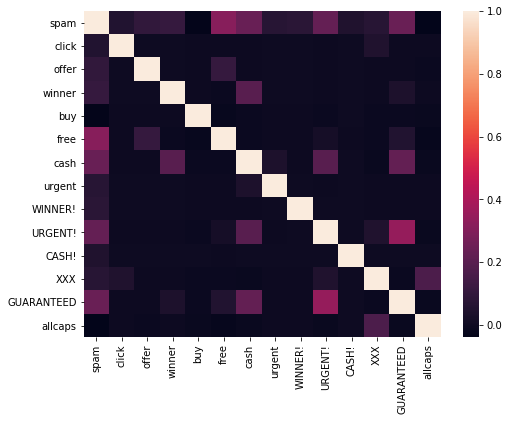

In [7]:
def draw_htmap(df):
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(df.corr())
    plt.show()
    
draw_htmap(sms_raw)

In [8]:
# Select each part of the overall df as either data or target.
data = sms_raw.loc[:, "click":]
target = sms_raw['spam']

In [9]:
# The data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()
#bnb = GaussianNB()
#bnb = ComplementNB()
#bnb = MultinomialNB()

# Combine 2 lines of code above into a single line here.
y_pred = bnb.fit(data, target).predict(data)

In [10]:
from sklearn.metrics import confusion_matrix

def evaluate(data, target, predicted):
    """
    Do all of the statistical evaluation of a classifier in one place.
    IN: the data being tested, target labels and predicted labels
    OUT: various tests, accuracy, specificity, sensitivity, and confusion matrix usage
    """
    
    total_points = data.shape[0]
    hits = (target == predicted).sum()
    misses = (target != predicted).sum()
    accuracy = (hits / data.shape[0]) * 100
    c_matr = confusion_matrix(target, y_pred)
    real_ham = (target == False).sum()
    real_spam = (target == True).sum()
    specificity = (c_matr[0][0] / real_ham) * 100
    sensitivity = (c_matr[1][1] / real_spam) * 100
    
    print("Total data points in the set: {}".format(total_points))
    
    print("Correct: {} ({} true negatives and {} true positives)".format(
        hits, c_matr[0][0], c_matr[1][1]))
    
    print("Mislabeled: {} ({} Type I / false alarms and {} Type II / misses)".format(
        misses, c_matr[0][1], c_matr[1][0]))
    
    print(f"Real test data: negatives {real_ham} positives {real_spam}")  
    print(f"\nAccuracy: {accuracy:.2f}%\nSpecificity: {specificity:.2f}%\nSensitivity: {sensitivity:.2f}%")

In [11]:
evaluate(data, target, y_pred)

Total data points in the set: 5572
Correct: 5021 (4770 true negatives and 251 true positives)
Mislabeled: 551 (55 Type I / false alarms and 496 Type II / misses)
Real test data: negatives 4825 positives 747

Accuracy: 90.11%
Specificity: 98.86%
Sensitivity: 33.60%


### Trying simple holdout group to see if it changes at all
It did, but I'm not sure if that's significant or not

In [12]:
from sklearn.model_selection import train_test_split

# Size is a percentage, 30% is apparently common,
# but can be anything from 1 - 50%.
holdout_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=holdout_size, random_state=50)

print(f'With {holdout_size*100}% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 30.0% Holdout: 0.9120813397129187
Testing on Sample: 0.9011127063890882


### Now I'll do some cross-validation
Up and down, but still clustered in essentially the same place; essentially no change, and worse than just a plain holdout.

In [13]:
from sklearn.model_selection import cross_val_score

# Will try 5 splits and see
cross_val_score(bnb, data, target, cv=5)

array([0.9058296 , 0.90044843, 0.90394973, 0.8940754 , 0.89856373])

### Time to modify some features

In [14]:
# Reset the dataframe
sms_raw = pd.read_csv('HamSpam', delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

In [15]:
# Get a bit more sophisticated with regexps
keywords = ([r"click", "click"],
            [r"offer", "offer"],
            [r"winner", "winner"],
            [r"buy", "buy"],
            [r"free", "free"],
            [r"\b(cash|CASH)!?\b", "cash"],
            [r"urgent", "urgent"],
            [r"\b(xxx|XXX)!?\b", "xxx"],
            [r"\bGUARANTEED?!?\b", "guarantee"])

for pattern, word in keywords:
    sms_raw[str(word)] = sms_raw['message'].str.contains(pattern, case=False)

# If the entire message is in caps, classify as spam.
sms_raw['allcaps'] = sms_raw['message'].str.isupper()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]


In [16]:
# Only run once, or everything goes False.
sms_raw['spam'] = (sms_raw['spam'] == 'spam')

In [17]:
sms_raw.head()

,spam,message,click,offer,winner,buy,free,cash,urgent,xxx,guarantee,allcaps
0,False,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False,False,False
1,False,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False,False,False
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,True,False,False,False,False,False
3,False,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False,False,False,False
4,False,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False,False,False,False


In [18]:
# Select each part of the overall df as either data or target.
data = sms_raw.loc[:, "click":]
target = sms_raw['spam']

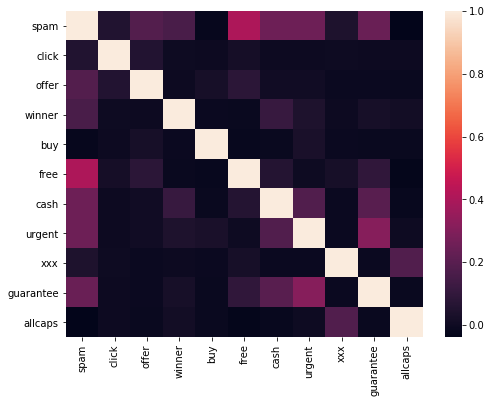

In [19]:
draw_htmap(sms_raw)

In [20]:
holdout_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=holdout_size, random_state=50)

print(f'With {holdout_size*100}% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 30.0% Holdout: 0.9222488038277512
Testing on Sample: 0.9124192390524049


In [21]:
y_pred = bnb.fit(data, target).predict(data)
evaluate(data, target, y_pred)

Total data points in the set: 5572
Correct: 5084 (4732 true negatives and 352 true positives)
Mislabeled: 488 (93 Type I / false alarms and 395 Type II / misses)
Real test data: negatives 4825 positives 747

Accuracy: 91.24%
Specificity: 98.07%
Sensitivity: 47.12%


In [22]:
# Reset the dataframe
sms_raw = pd.read_csv('HamSpam', delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

In [23]:
# Get a bit more sophisticated with regexps
keywords = ([r"\b(click|CLICK)!?\b", "click"],
            [r"\b(offer|OFFER)!?\b", "offer"],
            [r"\b(winner|WINNER)!?\b", "winner"],
            [r"\b(buy|BUY)!?\b", "buy"],
            [r"\b(free|FREE)!?\b", "free"],
            [r"\b(cash|CASH)!?\b", "cash"],
            [r"\b(urgent|URGENT)!?\b", "urgent"],
            [r"\b[Xx]{3}!?\b", "xxx"],
            [r"\bGUARANTEED?!?\b", "guarantee"],
            [r"\bto claim\b", "to_claim"],
            [r"\b(expire(s|d)?|EXPIRE(S|D)?)\b", "expire"])

for pattern, word in keywords:
    sms_raw[str(word)] = sms_raw['message'].str.contains(pattern, case=False)

# If the entire message is in caps, classify as spam.
sms_raw['allcaps'] = sms_raw['message'].str.isupper()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


In [24]:
# Only run once, or everything goes False.
sms_raw['spam'] = (sms_raw['spam'] == 'spam')

In [25]:
sms_raw.head(10)

,spam,message,click,offer,winner,buy,free,cash,urgent,xxx,guarantee,to_claim,expire,allcaps
0,False,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False,False,False,False,False
1,False,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False,False,False,False,False
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,True,False,False,False,False,False,False,False
3,False,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False,False,False,False,False,False
4,False,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False,False,False,False,False,False
5,True,FreeMsg Hey there darling it's been 3 week's n...,False,False,False,False,False,False,False,True,False,False,False,False
6,False,Even my brother is not like to speak with me. ...,False,False,False,False,False,False,False,False,False,False,False,False
7,False,As per your request 'Melle Melle (Oru Minnamin...,False,False,False,False,False,False,False,False,False,False,False,False
8,True,WINNER!! As a valued network customer you have...,False,False,True,False,False,False,False,False,False,True,False,False
9,True,Had your mobile 11 months or more? U R entitle...,False,False,False,False,True,False,False,False,False,False,False,False


In [26]:
# Select each part of the overall df as either data or target.
data = sms_raw.loc[:, "click":]
target = sms_raw['spam']

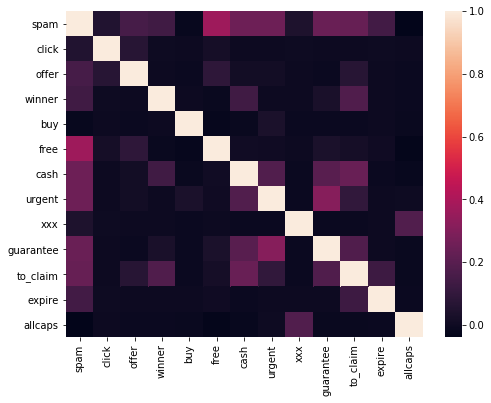

In [27]:
draw_htmap(sms_raw)

In [28]:
holdout_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=holdout_size, random_state=50)

print(f'With {holdout_size*100}% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 30.0% Holdout: 0.9216507177033493
Testing on Sample: 0.9133165829145728


In [29]:
y_pred = bnb.fit(data, target).predict(data)
evaluate(data, target, y_pred)

Total data points in the set: 5572
Correct: 5089 (4740 true negatives and 349 true positives)
Mislabeled: 483 (85 Type I / false alarms and 398 Type II / misses)
Real test data: negatives 4825 positives 747

Accuracy: 91.33%
Specificity: 98.24%
Sensitivity: 46.72%


In [100]:
# Reset the dataframe
sms_raw = pd.read_csv('HamSpam', delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

In [101]:
# Get a bit more sophisticated with regexps
keywords = ([r"\boffer!?", "offer"],
            [r"\bwinner!?", "winner"],
            [r"\bfree!?\b", "free"],
            [r"\bcash!?\b", "cash"],
            [r"\burgent!?", "urgent"],
           # [r"\b[Xx]{3,}!?", "xxx"],
            [r"\bto claim\b", "to_claim"],
            #[r"\bexpire(s|d)?\b", "expire"],
            [r"\bnokia\b", "nokia"],
            [r"optout\b", "optout"],
            [r"\b(un)?subscribe\b", "subscribe"],
            [r"(\text stop|2?stop ?te?xts?)\b", "stoptxt"],
            [r"\bcustcare\b", "custcare"],
            [r"\bringtone\b", "ringtone"],
            [r"\bprivate!?", "private"],
            [r"\bdouble\b", "double"])

for pattern, word in keywords:
    sms_raw[str(word)] = sms_raw['message'].str.contains(pattern, case=False)
    
capwords = ([r"\bGUARANTEE(D|S)?!?\b", "guarantee"],)

for pattern, word in capwords:
    sms_raw[str(word)] = sms_raw['message'].str.contains(pattern, case=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [102]:
# Only run once, or everything goes False.
sms_raw['spam'] = (sms_raw['spam'] == 'spam')

In [111]:
sms_raw.head(2)

,spam,message,offer,winner,free,cash,urgent,to_claim,nokia,optout,subscribe,stoptxt,custcare,ringtone,private,double,guarantee
0,False,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [103]:
# Select each part of the overall df as either data or target.
data = sms_raw.loc[:, "offer":]
target = sms_raw['spam']

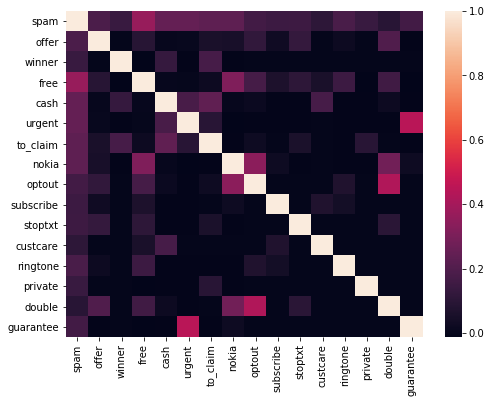

In [104]:
draw_htmap(sms_raw)

In [105]:
holdout_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=holdout_size, random_state=50)

print(f'With {holdout_size*100}% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 30.0% Holdout: 0.93122009569378
Testing on Sample: 0.923007896625987


In [113]:
# I can't seem to get better than this
cross_val_score(bnb, data, target, cv=5)

array([0.92735426, 0.92914798, 0.93087971, 0.90574506, 0.92010772])

In [106]:
y_pred = bnb.fit(data, target).predict(data)
evaluate(data, target, y_pred)

Total data points in the set: 5572
Correct: 5143 (4735 true negatives and 408 true positives)
Mislabeled: 429 (90 Type I / false alarms and 339 Type II / misses)
Real test data: negatives 4825 positives 747

Accuracy: 92.30%
Specificity: 98.13%
Sensitivity: 54.62%


### Make some comparisons to find out where I'm really having problems ('free' is one).  I'm comparing each feature to find out where they are true positives vs. false positives

In [117]:
for col in sms_raw.columns[2:]:
    print(col, sms_raw.loc[(sms_raw["spam"] == True) & (sms_raw[col] == True), col].sum(),
          sms_raw.loc[(sms_raw["spam"] == False) & (sms_raw[col] == True), col].sum())

offer 38 8
winner 17 0
free 170 59
cash 66 12
urgent 62 7
to_claim 47 0
nokia 50 3
optout 23 0
subscribe 19 0
stoptxt 20 0
custcare 10 0
ringtone 29 0
private 18 1
double 13 6
guarantee 23 0


In [114]:
#sms_raw[(sms_raw["free"] == True) & (sms_raw["spam"] == False)]